In [1]:
!pip install pygame
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np
import random
import gym
import pygame
from collections import deque

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

     |████████████████████████████████| 11.8MB 273kB/s 
pygame 2.0.1 (SDL 2.0.14, Python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


#Agent

In [2]:
class DQNAgent:
    def __init__(self, inputShape, outputShape, modelName = None):

        # Main model
        if modelName is None:
            self.model = self.create_model(inputShape, outputShape)
        else:
            self.model = load_model(modelName)

        # Target network
        self.target_model = self.create_model(inputShape, outputShape)
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self, inputShape, outputShape):
        model = Sequential()

        # model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
        # model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(Dropout(0.2))

        # model.add(Conv2D(256, (3, 3)))
        # model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(Dropout(0.2))

        # model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(128, input_shape=inputShape, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(32, activation = 'relu'))
        model.add(Dense(16, activation = 'relu'))
        model.add(Dense(outputShape, activation='linear'))  # ACTION_SPACE_SIZE = how many choices (9)
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape))[0]

#Snake Env

In [3]:
class SnakeEnv(object):
    def __init__(self):
        self.SCREEN_SIZE = 800
        self.vel = None
        self.gridSize = int(self.SCREEN_SIZE/160)
        self.foodPos = None
        self.spawnPos = None
        self.parts = []
        # self.screen = pygame.display.set_mode((self.SCREEN_SIZE, self.SCREEN_SIZE), 0, 32)
        # self.surface = pygame.Surface(self.screen.get_size()).convert()
        self.score = 0
        self.clock = pygame.time.Clock()
        self.framesLeft= 30
        pygame.init()
    def getBestAction(self):
        horizAction = -1
        vertAction = -1
        if self.parts[0][0]-self.foodPos[0] < 0:
            horizAction = 3
        elif self.parts[0][0]-self.foodPos[0] > 0:
            horizAction = 2
        if self.parts[0][1] - self.foodPos[1] < 0:
            vertAction = 1
        elif self.parts[0][1] - self.foodPos[1] > 0:
            vertAction = 0
        if horizAction == -1:
            return vertAction
        elif vertAction == -1:
            return horizAction
        elif random.random() > 0.5:
            return horizAction
        return vertAction
    def getNewHeadPos(self):
        a = self.parts[0]
        b = self.vel
        x = (a[0]+b[0])#(+self.gridSize) %self.gridSize
        y = (a[1]+b[1])#(+self.gridSize) %self.gridSize
        return (x,y)
    def rect(self,x,y,w,h,c):
        pygame.draw.rect(self.surface, c, pygame.Rect((x,y), (w,h)))
    def up(self):
        self.vel = (0, -1)
    def down(self):
        self.vel = (0, 1)
    def left(self):
        self.vel = (-1, 0)
    def right(self):
        self.vel = (1, 0)
    def getDistToFood(self):
      return abs(self.foodPos[0]-self.parts[0][0]) + abs(self.foodPos[1]-self.parts[0][1])
    def randomizeFoodPos(self):
        while True:
            self.foodPos = (random.randrange(self.gridSize),random.randrange(self.gridSize))
            if not self.foodPos in self.parts:
                return
    def updateBodyPos(self):
        newHeadPos = self.getNewHeadPos()
        if len(self.parts)>1 and newHeadPos == self.parts[1]:
            return 1
        for i in range(len(self.parts)-1,0,-1):
            self.parts[i] = self.parts[i-1]
        self.parts[0] = self.getNewHeadPos()
        return 0
    def drawBody(self):
        for part in self.parts:
            self.rect((part[0]*(self.SCREEN_SIZE/self.gridSize))+5,(part[1]*(self.SCREEN_SIZE/self.gridSize))+5,(self.SCREEN_SIZE/self.gridSize)-10,(self.SCREEN_SIZE/self.gridSize)-10,(0,0,255))
    def drawFood(self):
        self.rect((self.foodPos[0]*(self.SCREEN_SIZE/self.gridSize))+10,(self.foodPos[1]*(self.SCREEN_SIZE/self.gridSize))+10,(self.SCREEN_SIZE/self.gridSize)-20,(self.SCREEN_SIZE/self.gridSize)-20,(255,0,0))
    def reset(self):
        self.parts = [(0,0),(1,0)]
        self.vel = (1,0)
        self.randomizeFoodPos()
        self.score = 0
        self.framesLeft = 30
        return self.getNNInput()
    def getNNInput(self):
        gridInputs = [[0 for i in range(self.gridSize)] for j in range(self.gridSize)]
        for part in self.parts[1:]:
          gridInputs[part[0]][part[1]] = -1
        if self.parts[0][0] >= 0 and self.parts[0][1] >= 0 and self.parts[0][0] < self.gridSize and self.parts[0][1] < self.gridSize:
          gridInputs[self.parts[0][0]][self.parts[0][1]] = -0.5
        gridInputs[self.foodPos[0]][self.foodPos[1]] = 1
        return np.array(gridInputs).flatten()
    def step(self, action):
        frameScore = 0
        self.framesLeft-=1
        if action==0:
            self.up()
        if action==1:
            self.down()
        if action==2:
            self.left()
        if action==3:
            self.right()
        spawnPos = self.parts[-1]
        oldDist = self.getDistToFood()
        err = self.updateBodyPos()
        newDist = self.getDistToFood()
        if self.framesLeft<0 or err or self.parts[0] in self.parts[1:] or (self.parts[0][0] < 0 or self.parts[0][1] < 0 or self.parts[0][0] >= self.gridSize or self.parts[0][1] >= self.gridSize):
            return self.getNNInput(), -100, True, 'Info'
        elif self.parts[0]==self.foodPos:
            self.parts.append(spawnPos)
            self.score+=1
            self.framesLeft+=20
            if len(self.parts)==self.gridSize*self.gridSize:
              return self.getNNInput(), 10_000, True, 'Info'
            self.randomizeFoodPos()
            frameScore = 1
        return self.getNNInput(), 150*frameScore, False, 'Info'
    def render(self):
        self.surface = pygame.Surface(self.screen.get_size()).convert()
        self.drawBody()
        self.drawFood()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.display.quit()
        self.screen.blit(self.surface, (0,0))
        pygame.display.update()

#Main Code

In [4]:
def live_plot(y, training_steps):
    clear_output(wait=True)
    plt.figure(figsize=(20,5))
    x = list(range(len(y)))
    plt.xlim(0, training_steps)
    # plt.ylim(0, 200)
    
    if len(y) > 1:
        plt.scatter(x,y)
        plt.plot(x,y)
    plt.show()

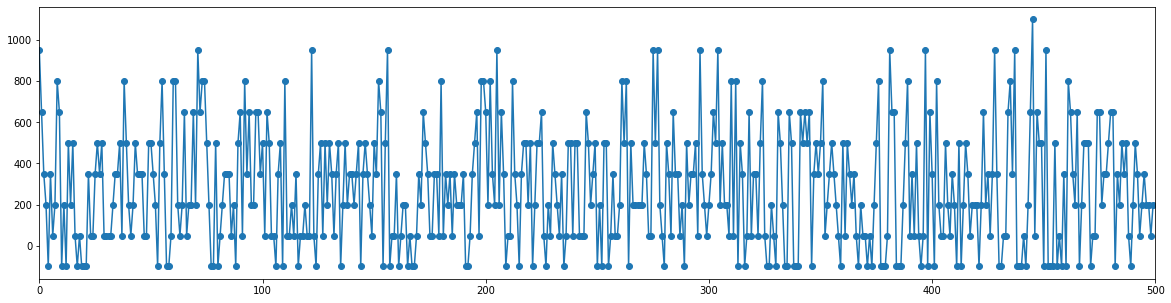

Episode:  10000 score: 200.00


In [5]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)

# Environment settings
EPISODES = 10_000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.9998
MIN_EPSILON = 0.001

#  Stats settings
env = SnakeEnv()
possibleActions = 4
AGGREGATE_STATS_EVERY = 50  # episodes
SHOW_PREVIEW = False
agent = DQNAgent((env.gridSize*env.gridSize,),4)

# Iterate over episodes
allRewards = []
for episode in range(1, EPISODES + 1):

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = env.getBestAction()
            # action = np.random.randint(0, possibleActions)

        new_state, reward, done, _ = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env.render()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1
        if done:
          break
    allRewards.append(episode_reward)
    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
    live_plot(allRewards[max(0,episode-500):episode], 500)
    print('Episode: ', episode, 'score: %.2f' % episode_reward)
    if episode%500==0:
      agent.model.save('model'+str(episode)+'.h5')

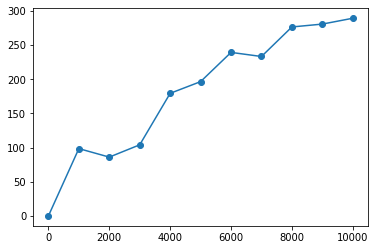

In [32]:
entries = 1000
rewardsAvg = [0]
for i in range(0, len(allRewards)-1, entries):
  rewardsAvg.append(sum(allRewards[i:i+entries])/entries)
plt.scatter(list(range(1, len(rewardsAvg)*entries, entries)), rewardsAvg)
plt.plot(list(range(1, len(rewardsAvg)*entries, entries)), rewardsAvg)